In [29]:
# add linc to path
#import sys
from eval.tasks.utils import evaluate

# set PROVER9 to /home/linuxbrew/.linuxbrew/bin/prover9
import os
os.environ["PROVER9"] = "/usr/local/bin/prover9"

import json

# make confusion matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
colors_lightest = ['#EAC5B6', '#FEEBBD', '#DDDADA', '#B6B9D6', '#B6E2F3', '#C7EFE9', '#F1ECF1']
colors_light = ['#B94700', '#F0B323', '#898D8D', '#151F6D', '#009CDE', '#49C5B1', '#C7C9C7']
colors_dark = ['#6D2B00', '#906B13', '#515555', '#0D1341', '#005C86', '#2D7569', '#777977']
colors = list(zip(colors_lightest, colors_light, colors_dark))
mpl.rc("font", family="serif", size=28)
import pandas as pd
import numpy as np

from eval.tasks.folio import FOLIOBase

import re

In [30]:
f = FOLIOBase("neurosymbolic", 1)
references = [i["label"] for i in f._test]

Using custom data configuration benlipkin--folio-8ac58b061299603e
Found cached dataset json (/home/theoxo/.cache/huggingface/datasets/benlipkin___json/benlipkin--folio-8ac58b061299603e/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration metaeval--folio-cc60a372b367c680
Found cached dataset json (/home/theoxo/.cache/huggingface/datasets/metaeval___json/metaeval--folio-cc60a372b367c680/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/theoxo/.cache/huggingface/datasets/metaeval___json/metaeval--folio-cc60a372b367c680/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-f906b4922be78567.arrow
Loading cached processed dataset at /home/theoxo/.cache/huggingface/datasets/metaeval___json/metaeval--folio-cc60a372b367c680/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-8065b259b0f66d00.arrow
Loading cached processed dataset at /home/theoxo/.cache/huggingface/datasets/benlipkin___json/benlipkin--folio-8ac58b061299603e/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-d904635de21770d3.arrow
Loading cached processed dataset at /home/theoxo/.cache/huggingface/datasets/benlipkin___json/benlipkin--folio-8ac58b061299603e/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-c14f8966d2d2f37a.arrow
Loading cached shuffled indices for dataset at /home/theoxo/.cache/huggingface/datasets/benl

In [31]:
import json
def read_results(model, dataset, mode, num_shots):
    if model == "gpt-3.5":
        model = "gpt-3.5-turbo-16k-0613"
    if model == "gpt-4":
        model = "gpt-4-0613"
    prc = json.load(open(f"../../outputs/{model}_{dataset}-{mode}-{num_shots}shot_generations_prc.json", "r")) # processed label estimates [100, 10]
    raw = json.load(open(f"../../outputs/{model}_{dataset}-{mode}-{num_shots}shot_generations_raw.json", "r")) # raw prompt and output [100, 10]
    results = json.load(open(f"../../outputs/{model}_{dataset}-{mode}-{num_shots}shot_results.json", "r")) # scores
    return prc, raw, results

In [32]:
from collections import Counter
def get_majority_vote(gens):
    gens = [i for i in gens if i != "Error"]
    if len(gens) == 0:
        return "Error"
    return Counter(gens).most_common(1)[0][0]

In [33]:
norm = plt.Normalize(vmin=0., vmax=100)

def make_confusion_matrix(preds, references, title="Figure", save_file="figures/figure.png",
                          xlabel="Reference Label", ylabel="Predicted Label",
                          colors=None):
    labels = ["True", "False", "Uncertain", "Error"] if "True" in preds else ["Correct", "Incorrect"]
    cm = confusion_matrix(preds, references, labels=labels)
    print(cm)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.tick_params(pad=10)
    cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', colors, N=256)
    sns.heatmap(cm, cmap=cmap, annot=True, fmt='g', norm=norm)
    plt.xticks(ticks=[x+0.5 for x in range(len(labels))], labels=labels)
    plt.yticks(ticks=[x+0.5 for x in range(len(labels))], labels=labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    plt.setp(ax.get_yticklabels(), rotation=-45, ha='right', rotation_mode='anchor')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.title(title, fontsize=24)
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    plt.savefig(save_file, dpi=600, bbox_inches = "tight")#, bbox='tight')


In [34]:
model = "gpt-4"

gpt4_prc_neurosym, gpt4_raw_neurosym, _ = read_results(model, "folio", "neurosymbolic", 8)
gpt4_preds_neurosym = [get_majority_vote(i) for i in gpt4_prc_neurosym]

gpt4_prc_cot, gpt4_raw_cot, _ = read_results(model, "folio", "cot", 8)
gpt4_preds_cot = [get_majority_vote(i) for i in gpt4_prc_cot]

gpt4_prc_baseline, gpt4_raw_baseline, _ = read_results(model, "folio", "baseline", 8)
gpt4_preds_baseline = [get_majority_vote(i) for i in gpt4_prc_baseline]

gpt4_prc_scratchpad, gpt4_raw_scratchpad, _ = read_results(model, "folio", "scratchpad", 8)
gpt4_preds_scratchpad = [get_majority_vote(i) for i in gpt4_prc_scratchpad]

starcoder_prc_neurosym, starcoder_raw_neurosym, _ = read_results("starcoderplus", "folio", "neurosymbolic", 8)
starcoder_preds_neurosym = [get_majority_vote(i) for i in starcoder_prc_neurosym]

starcoder_prc_cot, starcoder_raw_cot, _ = read_results("starcoderplus", "folio", "cot", 8)
starcoder_preds_cot = [get_majority_vote(i) for i in starcoder_prc_cot]

starcoder_prc_baseline, starcoder_raw_baseline, _ = read_results("starcoderplus", "folio", "baseline", 8)
starcoder_preds_baseline = [get_majority_vote(i) for i in starcoder_prc_baseline]

starcoder_prc_scratchpad, starcoder_raw_scratchpad, _ = read_results("starcoderplus", "folio", "scratchpad", 8)
starcoder_preds_scratchpad = [get_majority_vote(i) for i in starcoder_prc_scratchpad]

[[39  4  1  0]
 [ 0 31  0  0]
 [23 18 62  0]
 [ 1  1  2  0]]
[[50  1  7  0]
 [ 3 38  9  0]
 [10 15 49  0]
 [ 0  0  0  0]]


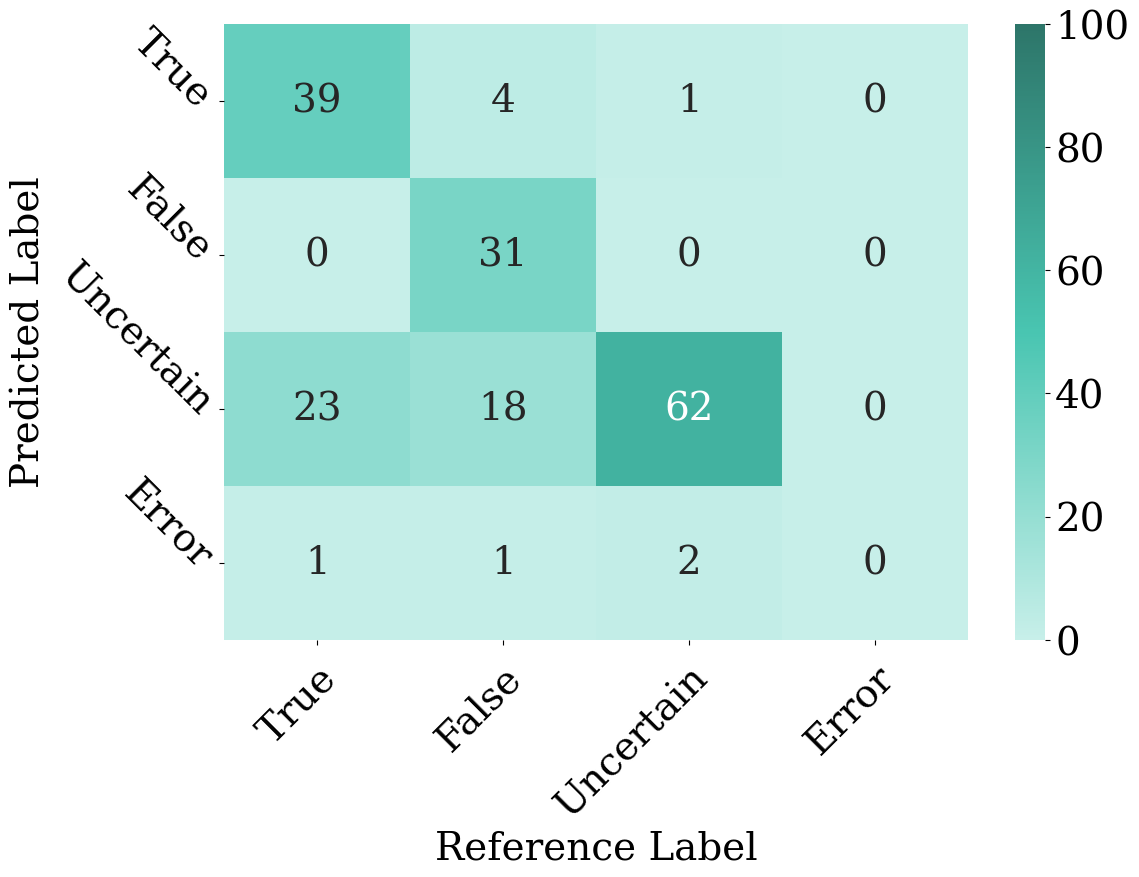

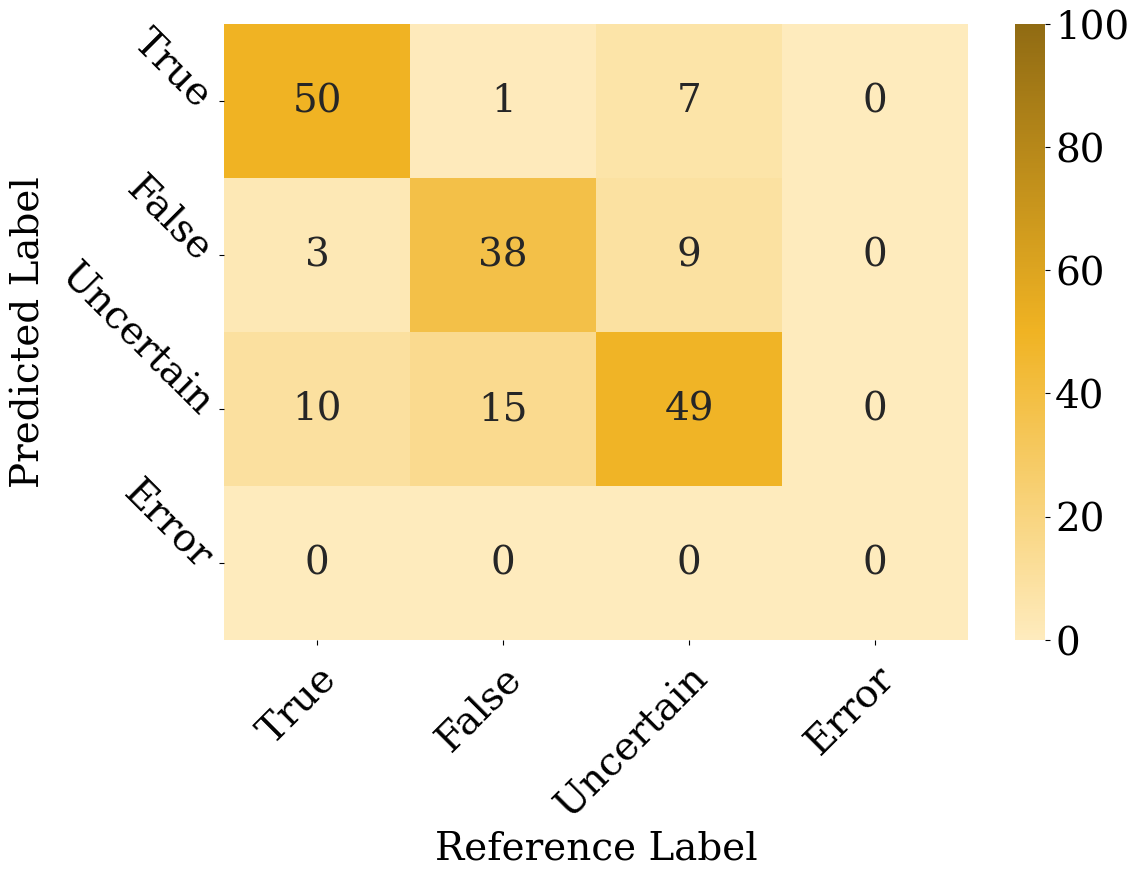

In [35]:
make_confusion_matrix(gpt4_preds_neurosym, references, "GPT-4 Confusion Matrix (8-shot, Neurosymbolic, 10-way majority vote)", "figures/gpt4_neurosym_confusion.pdf", colors=colors[5])
make_confusion_matrix(gpt4_preds_cot, references, "GPT-4 Confusion Matrix (8-shot, COT, 10-way majority vote)", "figures/gpt4_cot_confusion.pdf", colors=colors[1])


[[61 38 55  0]
 [ 1 12  7  0]
 [ 1  4  3  0]
 [ 0  0  0  0]]
[[31  7  6  0]
 [ 1 16  0  0]
 [25 29 55  0]
 [ 6  2  4  0]]


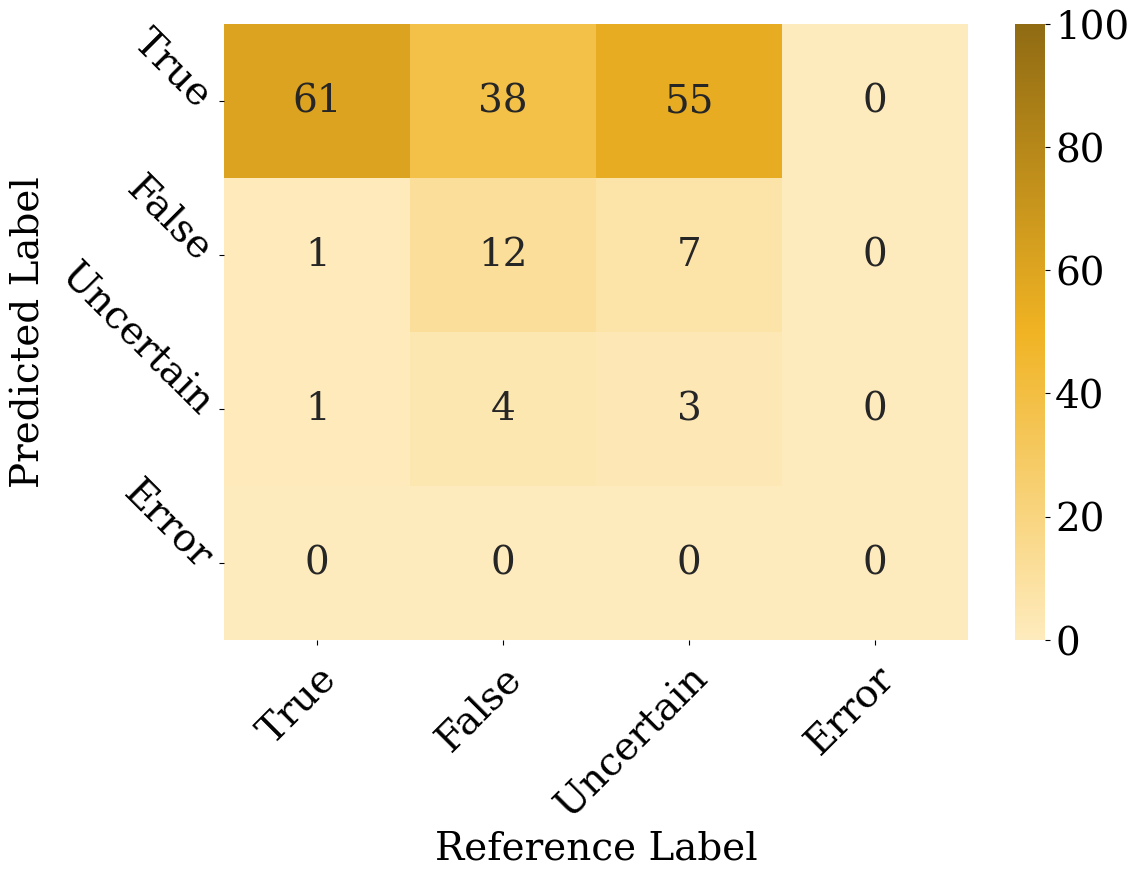

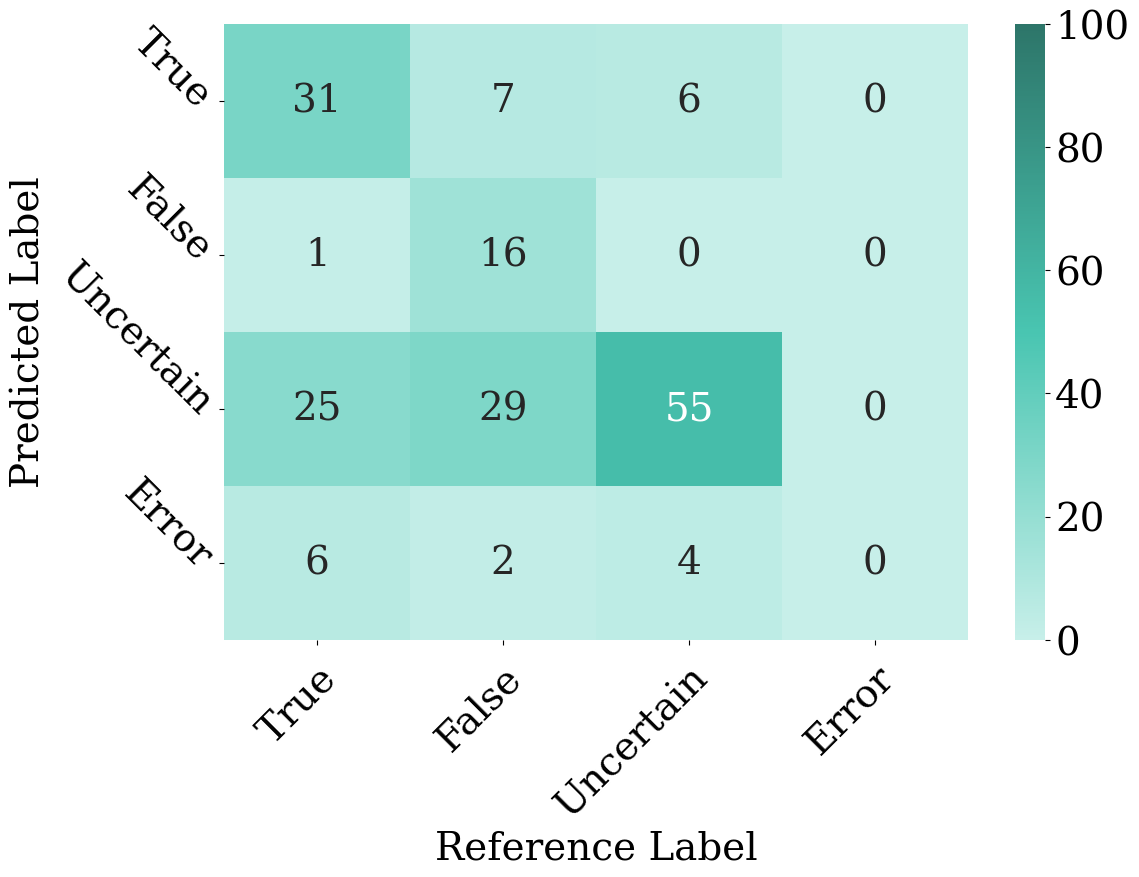

In [36]:
make_confusion_matrix(starcoder_preds_cot, references, "StarCoder+ Confusion Matrix (8-shot, COT, 10-way majority vote)", "figures/starcoder_cot_confusion.pdf", colors=colors[1])
make_confusion_matrix(starcoder_preds_neurosym, references, "StarCoder+ Confusion Matrix (8-shot, Neurosymbolic, 10-way majority vote)", "figures/starcoder_neurosym_confusion.pdf", colors=colors[5])

[[108  29]
 [ 24  21]]
[[37 39]
 [65 41]]


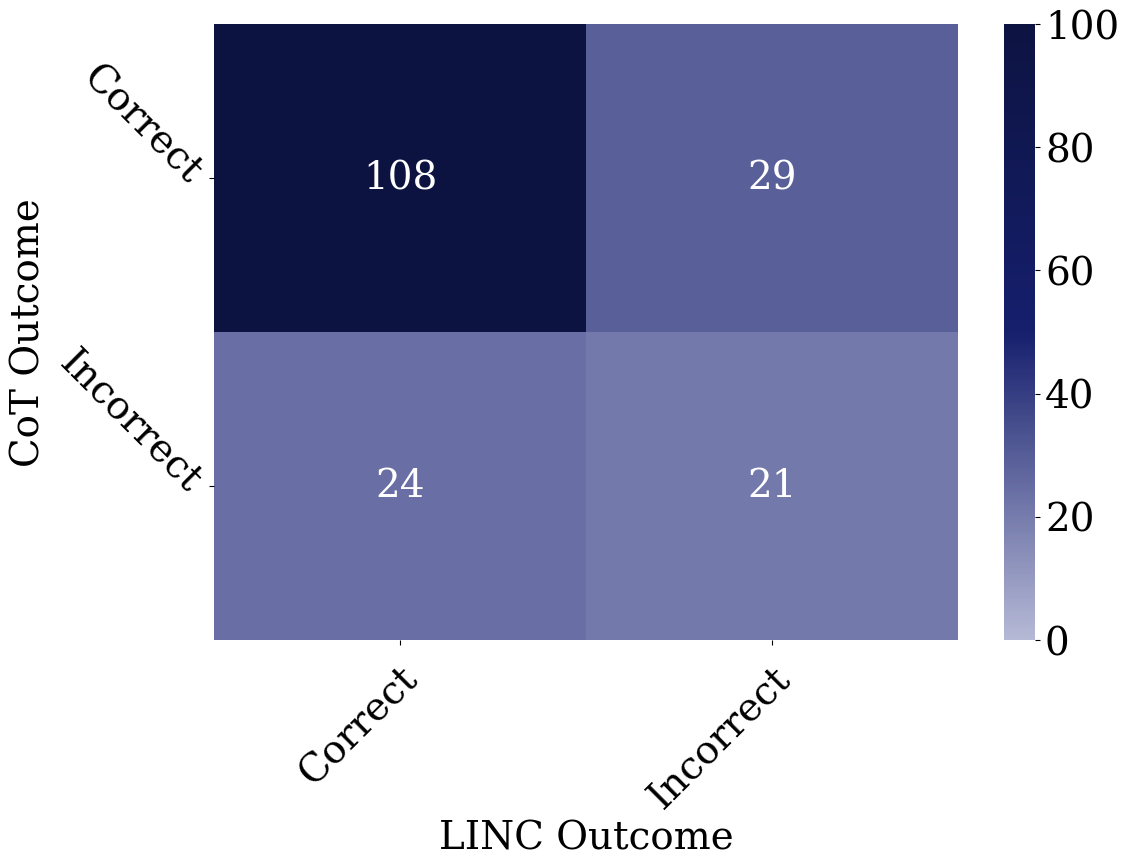

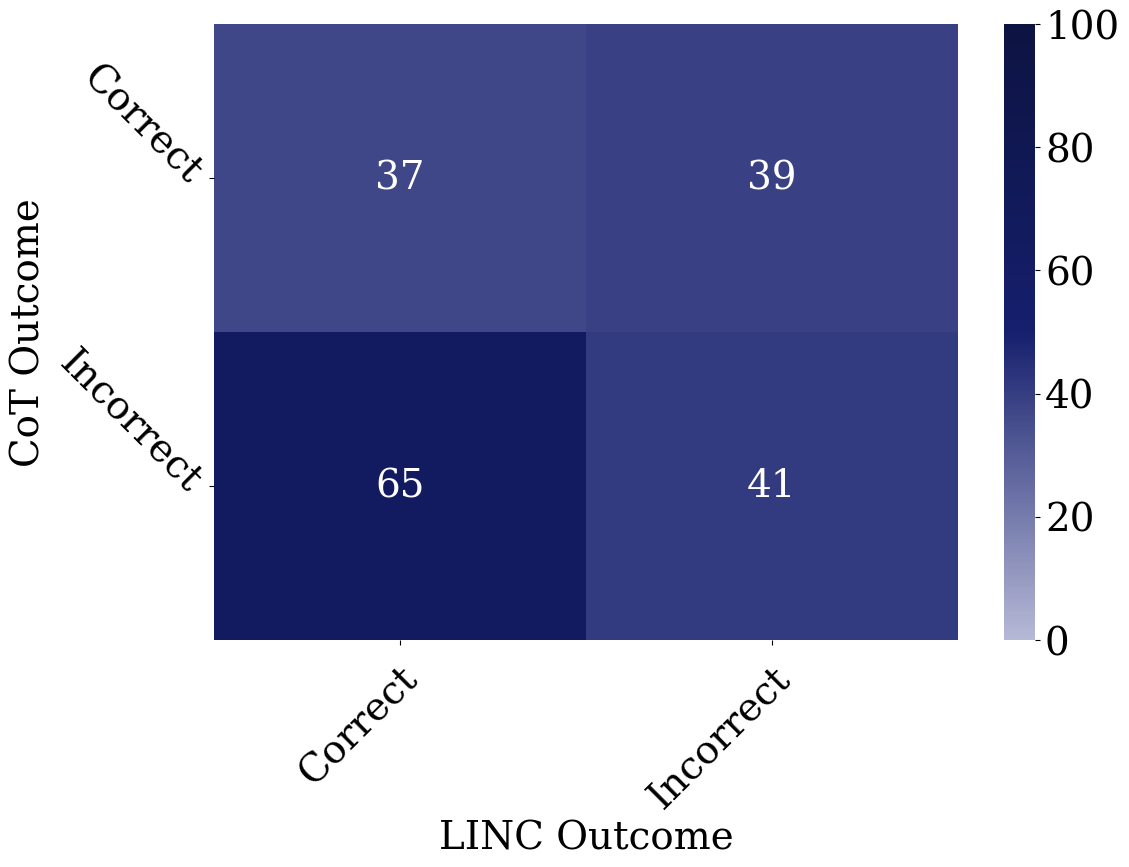

In [37]:
def get_itemized_results(predictions, references):
    result = []
    for i in range(len(predictions)):
        if predictions[i] == references[i]:
            result.append("Correct")
        else:
            result.append("Incorrect")
    return result
    

gpt4_neurosym_correct = get_itemized_results(gpt4_preds_neurosym, references)
gpt4_cot_correct = get_itemized_results(gpt4_preds_cot, references)
gpt4_baseline_correct = get_itemized_results(gpt4_preds_baseline, references)
gpt4_scratchpad_correct = get_itemized_results(gpt4_preds_scratchpad, references)

starcoder_neurosym_correct = get_itemized_results(starcoder_preds_neurosym, references)
starcoder_cot_correct = get_itemized_results(starcoder_preds_cot, references)

make_confusion_matrix(gpt4_cot_correct, \
    gpt4_neurosym_correct,
    title="GPT-4 Prediction Matrix (4-shot, 10-way majority)",
    save_file="figures/gpt-4_cot_neurosym.pdf",
    xlabel="LINC Outcome",
    ylabel="CoT Outcome",
    colors=colors[3])

make_confusion_matrix(starcoder_cot_correct, \
    starcoder_neurosym_correct,
    title="StarCoder+ Prediction Matrix (4-shot, 10-way majority)",
    save_file="figures/starcoder_cot_neurosym.pdf",
    xlabel="LINC Outcome",
    ylabel="CoT Outcome",
    colors=colors[3])

In [38]:
def plot_value_matrix(values, title="Figure", save_file="figures/figure.png", xlabel="Reference Label", ylabel="Predicted Label"):
    values = np.round(values, 2)
    labels = ["LINC", "CoT", "Scratchpad", "Naive"]
    df_cm = pd.DataFrame(values, index=labels, columns=labels)
    mask = np.tril(np.ones_like(df_cm, dtype=bool))
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.tick_params(pad=10)
    
    cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', colors[3], N=256)

    sns.heatmap(df_cm, annot=True, cmap=cmap, fmt='g', mask=~mask, cbar=True)#, annot_kws={"size": 20})
    #plt.rcParams["font.family"] = "DejaVu Sans"

    #plt.title(title)
    #plt.xlabel(xlabel)
    #plt.ylabel(ylabel)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    plt.setp(ax.get_yticklabels(), rotation=-45, ha='right', rotation_mode='anchor')
    #plt.title(title)
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    plt.savefig(save_file, dpi=600, bbox_inches='tight')
    plt.show()

In [39]:
def get_match(approach_1, approach_2, references):
    at_least_one_wrong = 0
    both_same_wrong = 0
    for i in range(len(approach_1)):
        if approach_1[i] != references[i] or approach_2[i] != references[i]:
            at_least_one_wrong += 1
        if approach_1[i] == approach_2[i] and approach_2[i] != references[i]:
        #if approach_1[i] != references[i] and approach_2[i] != references[i]:
            both_same_wrong += 1
    return both_same_wrong / at_least_one_wrong

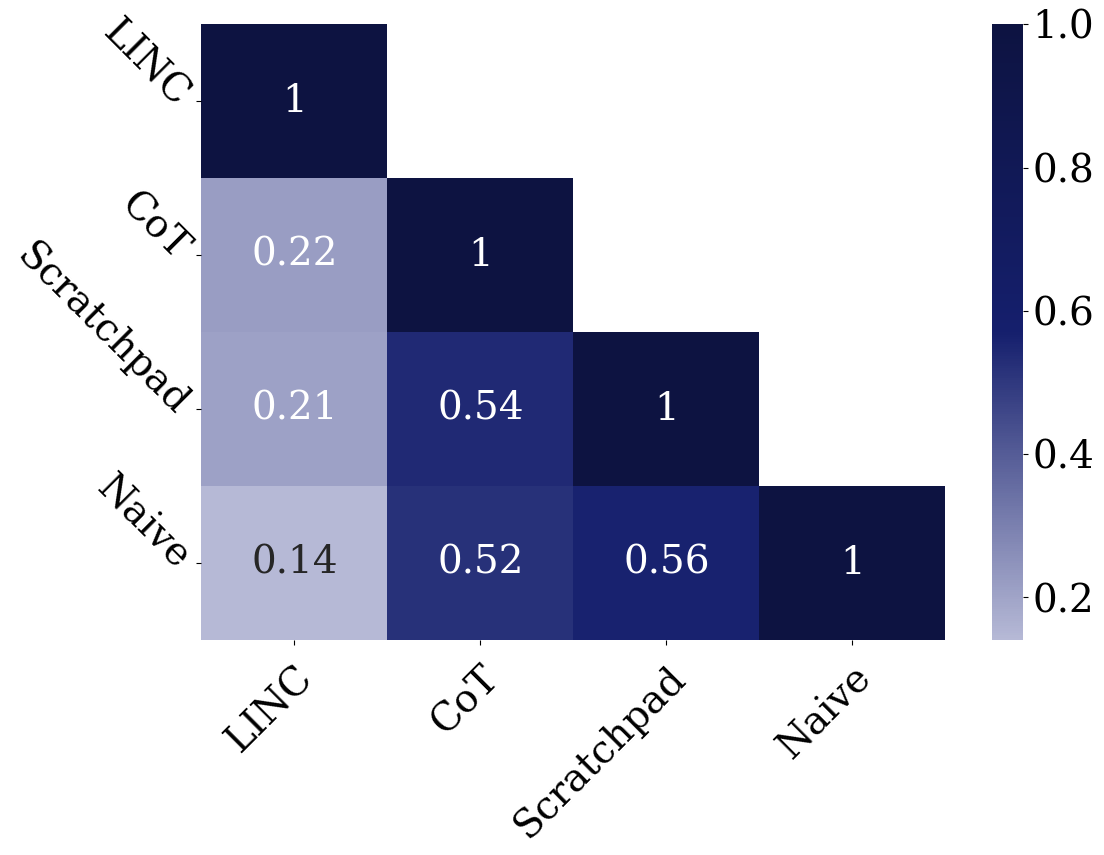

In [40]:
preds = [gpt4_preds_neurosym, gpt4_preds_cot, gpt4_preds_scratchpad, gpt4_preds_baseline]
values = [[0 for _ in range(4)] for _ in range(4)]
for i in range(4):
    for j in range(i, 4):
        values[i][j] = get_match(preds[i], preds[j], references)
        values[j][i] = values[i][j]

plot_value_matrix(values, title="Similarity between method wrong predictions (a wrong = b wrong) / (a wrong or b wrong)", xlabel="Method A", ylabel="Method B", save_file="figures/gpt-4_method_similarity.pdf")

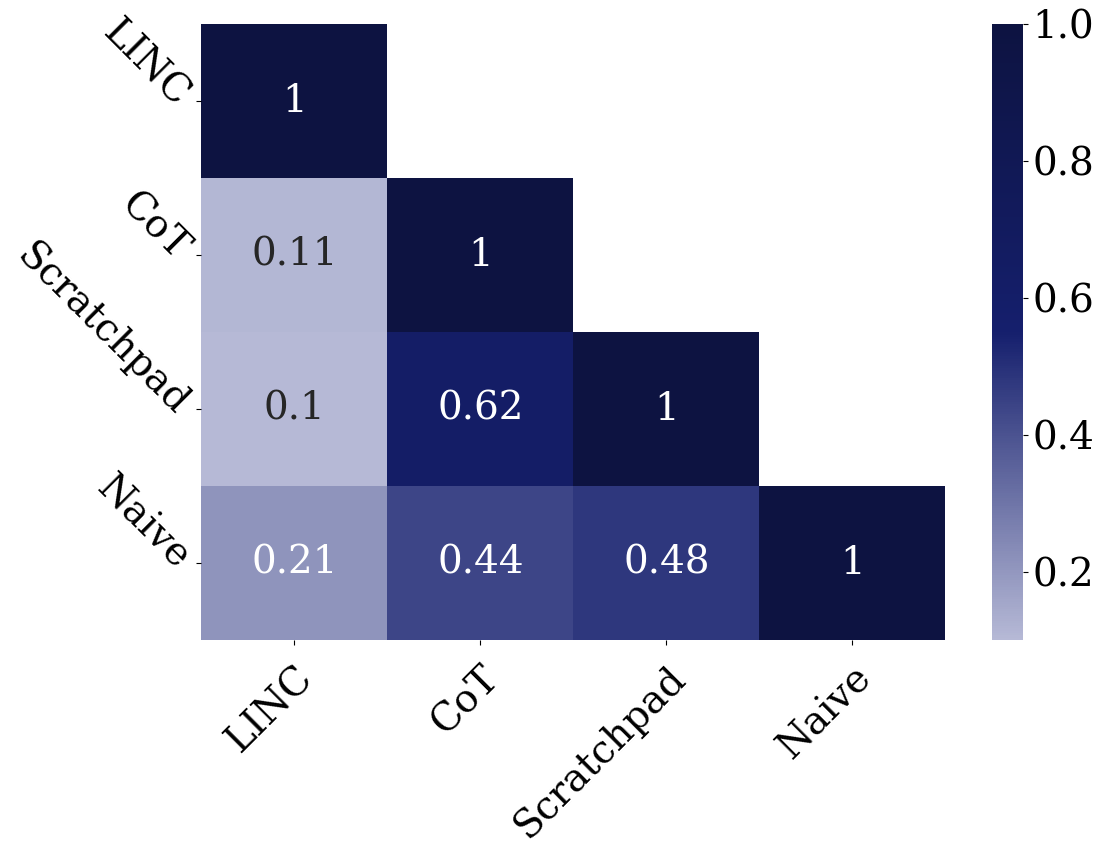

In [41]:
preds = [starcoder_preds_neurosym, starcoder_preds_cot, starcoder_preds_scratchpad, starcoder_preds_baseline]
values = [[0 for _ in range(4)] for _ in range(4)]
for i in range(4):
    for j in range(i, 4):
        values[i][j] = get_match(preds[i], preds[j], references)
        values[j][i] = values[i][j]

plot_value_matrix(values, title="Similarity between method wrong predictions (a wrong = b wrong) / (a wrong or b wrong)", xlabel="Method A", ylabel="Method B", save_file="figures/starcoder_method_similarity.pdf")